In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import ROOT
from scipy.interpolate import interp1d

In [2]:
mpl.rcParams.update({
    'text.usetex':     False,
    'mathtext.fontset':'cm',                
    'font.family':     'serif',
    'font.serif':      ['DejaVu Serif'],    
    'font.size':       12,
    'axes.labelsize':  14,
})

# Calculating our direction averaged effective area

This is the average effective area within the field of view of the telescope computed as 

$$    \langle A_{eff} (E_\nu) \rangle = \dfrac{1}{\Omega_{tot}} \int d\Omega \:
    A_{eff}(\phi, \theta, E_\nu) $$

The telescope aperture is also calculated and computed as 

$$      \langle A_{eff} \Omega (E_\nu) \rangle = \int d\Omega \:
    A_{eff}(\phi, \theta, E_\nu) = \int d\theta d \phi \cos{\theta} \:
    A_{eff}(\phi, \theta, E_\nu)$$

where $\phi$ is the azimuth angle and $\theta$ is the elevation

In [3]:
# Going from horizontal to equatorial coordinates
def horiz_to_equatorial(az_deg, alt_deg, lat_rad, lst_rad):
    az  = np.radians(az_deg)
    alt = np.radians(alt_deg)
    # declination
    sin_dec = np.sin(alt)*np.sin(lat_rad) + np.cos(alt)*np.cos(lat_rad)*np.cos(az)
    dec     = np.arcsin(sin_dec)
    # hour angle
    sin_ha = -np.sin(az)*np.cos(alt)/np.cos(dec)
    cos_ha = (np.sin(alt) - np.sin(lat_rad)*sin_dec)/(np.cos(lat_rad)*np.cos(dec))
    ha     = np.arctan2(sin_ha, cos_ha)
    # RA = LST − HA, mod 2π maps to [0,2π)
    ra = (lst_rad - ha) % (2*np.pi)
    return ra, dec

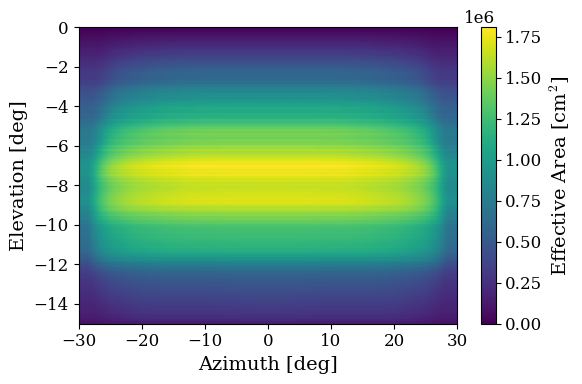

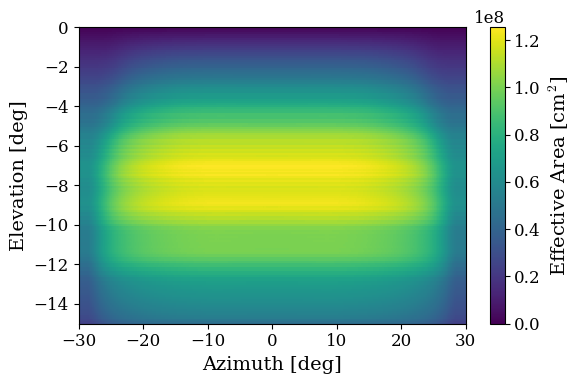

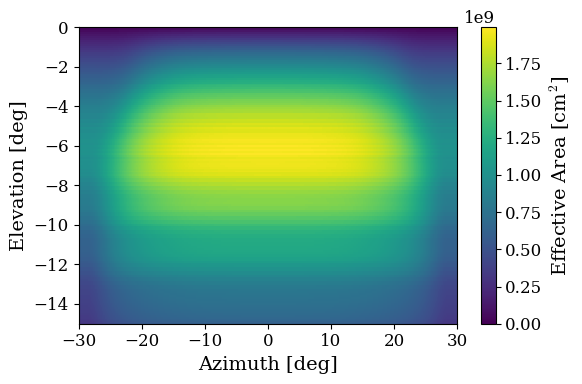

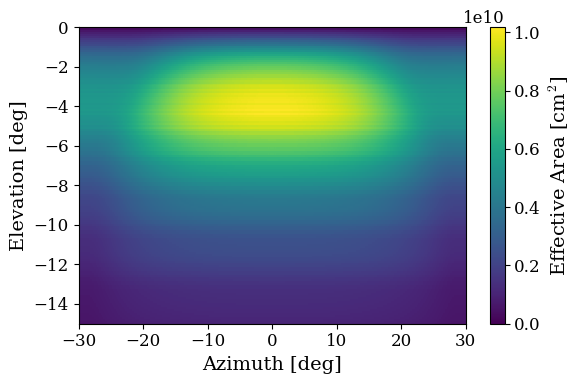

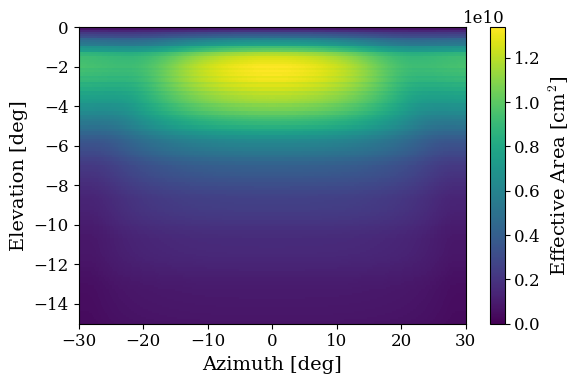

In [4]:
output_folder = 'skymaps_60FoV'
energies      = [5,6,7,8,9]  # log10(Emin) [GeV]
os.makedirs(output_folder, exist_ok=True)

A_int_list = []
A_avg_list = []
Omega_list = []
energies = [5,6,7,8,9] #log10(Emin) [GeV]

for i in energies:
    f = ROOT.TFile.Open(f"files/PointSourceAcceptance_FoV60.0deg_Index2.0_Emin{i}.5_Emax{i+1}.5.root")
    h2 = f.Get("skyAcceptance")
    if not h2:
        raise ValueError("Could not find 'skyAcceptance' in the file.")

    nx = h2.GetNbinsX()
    ny = h2.GetNbinsY()

    # read bin centers & widths
    phi_centers = np.array([h2.GetXaxis().GetBinCenter(ix) for ix in range(1,nx+1)])
    phi_widths  = np.array([h2.GetXaxis().GetBinWidth(ix)  for ix in range(1,nx+1)])
    elev_centers= np.array([h2.GetYaxis().GetBinCenter(jy) for jy in range(1,ny+1)])
    elev_widths = np.array([h2.GetYaxis().GetBinWidth(jy)  for jy in range(1,ny+1)])

    # load acceptance
    acceptance = np.zeros((nx, ny))
    for ix in range(1, nx+1):
        for jy in range(1, ny+1):
            acceptance[ix-1, jy-1] = h2.GetBinContent(ix, jy)

    # if your φ axis runs 0→360, shift to –180→+180 for masking
    phi_mod = (phi_centers + 180) % 360 - 180

    # build the weight matrix in radians
    dphi = np.radians(phi_widths)
    delev = np.radians(elev_widths)
    cosE  = np.cos(np.radians(elev_centers))
    weight = np.outer(dphi, delev * cosE)  # shape (nx, ny)

    # now select only the bins in your plotting window:
    phi_mask  = (phi_mod >= -30) & (phi_mod <=  30)
    elev_mask = (elev_centers >= -15) & (elev_centers <=   0)

    # apply mask
    A_sub    = acceptance[np.ix_(phi_mask, elev_mask)]
    W_sub    = weight    [np.ix_(phi_mask, elev_mask)]

    # integrate
    A_int = np.sum(A_sub * W_sub)  # [cm^2·sr]
    Omega = np.sum(W_sub)          # [sr]
    A_avg = A_int / Omega          # [cm^2]

    A_int_list.append(A_int)
    Omega_list.append(Omega)
    A_avg_list.append(A_avg)

    # (optional) re-plot just the subregion
    plt.figure(figsize=(6,4))
    plt.pcolormesh(
        phi_mod[phi_mask],
        elev_centers[elev_mask],
        A_sub.T,
        shading='auto'
    )
    plt.xlabel("Azimuth [deg]")
    plt.ylabel("Elevation [deg]")
    plt.colorbar(label="Effective Area [cm$^2$]")
    plt.xlim([-30,30])
    plt.ylim([-15,0])
    plt.tight_layout()
    plt.show()

# final summary plot
energies = [10**(i+1) for i in energies]


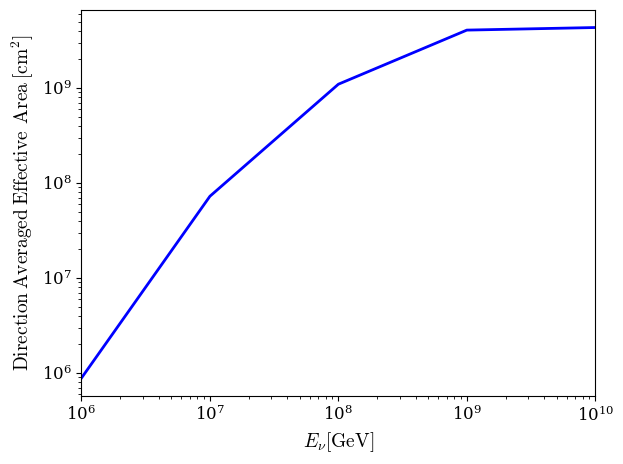

Solid angles (sr) in the FoV are: [np.float64(0.2732858858029033), np.float64(0.2732858858029033), np.float64(0.2732858858029033), np.float64(0.2732858858029033), np.float64(0.2732858858029033)]


In [5]:
plt.figure()
plt.loglog(energies, A_avg_list, lw = '2', color = 'blue')
plt.xlabel(r'$E_\nu \rm{[GeV]}$')
plt.ylabel(r'$\rm{Direction\: Averaged\: Effective\:\:Area}\:[\rm{cm}^2]$')
plt.xlim([1e6,1e10])
plt.tight_layout()
plt.savefig('outputs/direction_averaged_effective_area.jpg')
plt.show()

print("Solid angles (sr) in the FoV are:", Omega_list)

In [6]:
# This is digitized from Fig. 10 in https://arxiv.org/pdf/2504.13271
beacon_eff = np.genfromtxt('files/BEACON_acceptance.csv', delimiter = ',')

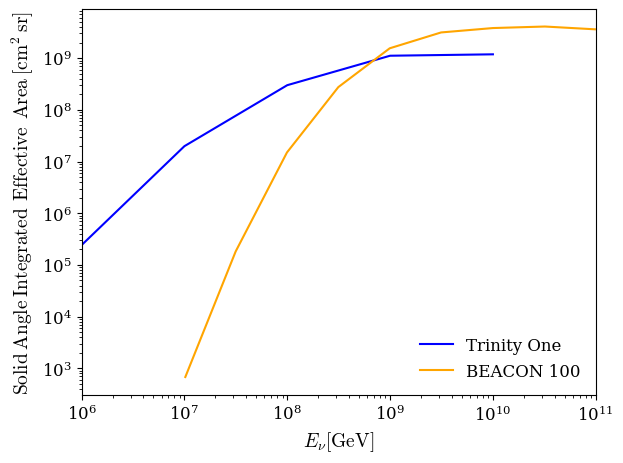

In [7]:
plt.figure()
plt.loglog(energies, A_int_list, color = 'blue', label = 'Trinity One')
plt.loglog(beacon_eff[:,0]*1e-9, beacon_eff[:,1]*1e10, color = 'orange', label = 'BEACON 100')
plt.legend(loc = 'lower right', frameon =  False)
plt.xlabel(r'$E_\nu \rm{[GeV]}$')
plt.ylabel(r'$\rm{Solid\:Angle\:Integrated\:\: Effective\:\:Area}\:[\rm{cm}^2\: \rm{sr}]$')
plt.xlim([1e6,1e11])
plt.tight_layout()
plt.savefig('outputs/solid_angle_integrated_eff_area.jpg')
plt.show()

# Instantaneous Skymaps

The following section plots skymaps from the Trinity Performance ROOT files onto the sky

In [8]:
#This cell is only to visualize the acceptance     
output_folder   = 'skymaps_60FoV'
latitude_deg    = 38.5217                       # degrees
lst_hours       = 0.00                      # local sidereal time (hours)

# Converting to radians
lat_rad = np.radians(latitude_deg)
lst_rad = np.radians(lst_hours * 15.0)       # hours → degrees → radians

energies = [5,6,7,8,9] #log10(Emin) [GeV]
Aeff_list = []

os.makedirs(output_folder, exist_ok=True)
for energy in energies:
    f   = ROOT.TFile.Open(f"files/PointSourceAcceptance_FoV60.0deg_Index2.0_Emin{energy}.5_Emax{energy+1}.5.root")
    h2  = f.Get("skyAcceptance")
    nx, ny = h2.GetNbinsX(), h2.GetNbinsY()

    # fill 2D acceptance array
    acceptance = np.array([
        [h2.GetBinContent(ix+1, iy+1) 
         for iy in range(ny)]
        for ix in range(nx)
    ])


    # bin centers
    x_centers = np.array([h2.GetXaxis().GetBinCenter(i+1) for i in range(nx)])
    y_centers = np.array([h2.GetYaxis().GetBinCenter(j+1) for j in range(ny)])

    # build and flatten grid
    az_grid, el_grid = np.meshgrid(x_centers, y_centers, indexing='ij')
    az_flat = az_grid.ravel()
    el_flat = el_grid.ravel()
    acc_flat = acceptance.ravel()

    Aeff_list.append(acc_flat)

    # convert
    ras, decs = horiz_to_equatorial(az_flat, el_flat, lat_rad, lst_rad)
    lon = np.pi - ras
    lon = (lon + np.pi) % (2*np.pi) - np.pi

    # plot
    fig, ax = plt.subplots(subplot_kw=dict(projection='mollweide'), figsize=(8,4.5))
    sc = ax.scatter(lon, decs, c=acc_flat, s=4, cmap='inferno')
    cb = fig.colorbar(sc, ax=ax, orientation='horizontal', pad=0.05)
    cb.set_label(r'$\rm{Effective \: Area} [\rm{cm}^2]$')
    ax.grid(True)
    ax.tick_params(axis='x', colors='white')
    ax.set_title(fr'$E_\nu \simeq 10^{{{energy+1:.1f}}}\,\mathrm{{GeV}}$')

    out_name = f'skymap_60deg_E{energy+1:.1f}.png'
    fig.savefig(os.path.join(output_folder, out_name), dpi=150)
    plt.close(fig)

    np.savez_compressed(
        os.path.join(output_folder, f'acceptance_{energy+1}'),
        lon=lon,
        decs=decs,
        events=acc_flat
    )
print("Done! Skymaps are in", output_folder)

Done! Skymaps are in skymaps_60FoV


# Short Burst Sensitivity Calculation

Fluence sensitivity to short duration bursts (<1000s) is calculated using the Feldman-Cousins upper limit per energy decade at a 90 \% confidence level for a background free observation and $E_\nu^{-2}$  spectrum:

$$E^2_\nu S(E_\nu) = \frac{2.44}{\Delta(\log_{10}E_\nu)} \frac{3}{\ln(10)} \frac{E_\nu}{A_{\text{eff}}}$$

Intergrating per decade in energy leads to $\Delta(\log_{10}E_\nu) = 1$. Moreover, the maximum effective area for each energy bin is considered 

In [22]:
# Parameters needed for rescaling flux
dL0 = 300 # MPc
pc2cm = 3.086e18
dL0 = dL0*1e6*pc2cm
dLnew = 40*1e6*pc2cm
erg2gev = 624.2

#digitized BEACON sensitivity from Ref 1. 
beacom_sensitivity = np.array([[31637495393844810, 50.19729006676903],
[99595422045481620, 1.785256735482341],
[316844416620464640, 0.21884471064600325],
[1000063099046728700, 0.10646598693830134],
[3189907926145838000, 0.17852567354823412],
[10084749419480117000, 0.43596917354484754],
[101782416339595330000, 4.159562163071841]])

In [23]:
# This are from Ref 2. 
shortGRBprompt_murase = np.genfromtxt('files/prompt_emission_murase.csv', delimiter = ',')
shortGRBextended_murase = np.genfromtxt('files/extended_emission_murase.csv', delimiter = ',')

# This are calculated for z = 0.151 (GRB 221009 A distance). Ref. 3. 
photosphere = np.genfromtxt('files/Photosphere_GRB.txt')
IShock = np.genfromtxt('files/Int_Shock_GRB.csv', delimiter = ',')
ICMART = np.genfromtxt('files/ICMART.csv', delimiter = ',')

In [24]:
energies = np.array([1e6,1e7,1e8,1e9,1e10])
int_max_eff_area_60 = interp1d(np.log10(energies*1e9),np.log10(max_eff_area),fill_value="extrapolate")
energy = np.logspace(np.log10(energies[0]*1e9),np.log10(energies[-1]*1e9),100) #eV

def neutrino_fluence_sensitivity(E):
    ratio = E/(10**int_max_eff_area_60(np.log10(E)))
    return 3*2.44/np.log(10)*ratio

In [25]:
max_eff_area = np.array([max(Aeff_list[0]),max(Aeff_list[1]),max(Aeff_list[2]),max(Aeff_list[3]),max(Aeff_list[4])])

In [26]:
neutrino_fluence_60 = [1e-9*neutrino_fluence_sensitivity(i) for i in energies] # GeV cm^-2

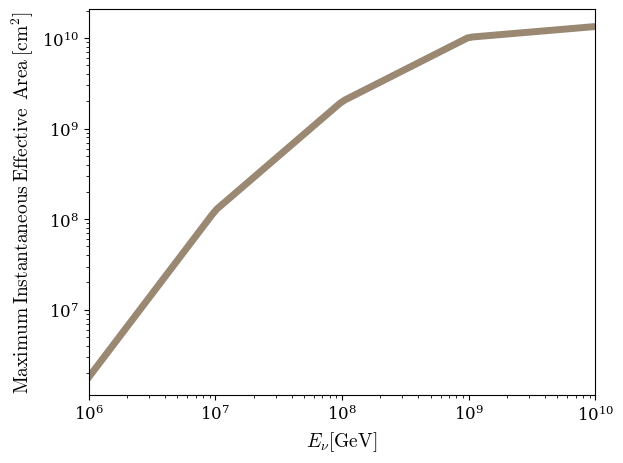

In [27]:
plt.loglog(energy*1e-9,10**int_max_eff_area_60(np.log10(energy)), label = 'hFoV = 60', color = '#9A8873', lw ='5')
plt.xlabel(r'$E_\nu \rm{[GeV]}$')
plt.ylabel(r'$\rm{Maximum\: Instantaneous\: Effective\:\:Area}\:[\rm{cm}^2]$')
plt.xlim([1e6,1e10])
plt.tight_layout()
plt.savefig('outputs/maximum_instantaneous_effective_area.jpg')
plt.show()

In [28]:
neutrino_fluence_60 = [1e-9*neutrino_fluence_sensitivity(i) for i in energy] # GeV cm^-2

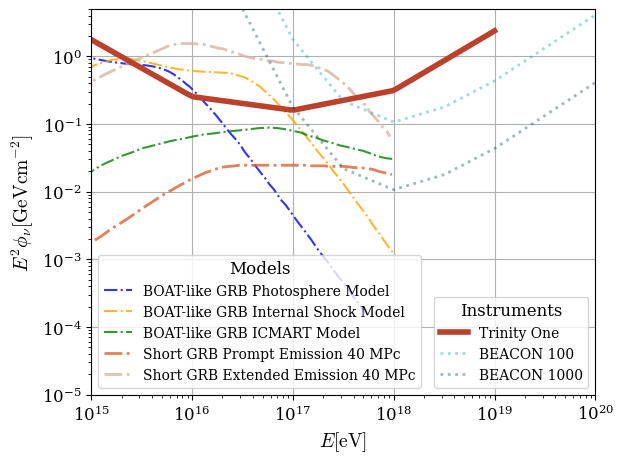

In [29]:
plt.loglog(photosphere[:,0]*1e9,photosphere[:,1], label = 'BOAT-like GRB Photosphere Model', c = 'blue', ls = '-.', alpha = 0.8)
plt.loglog(IShock[:,0]*1e9,IShock[:,1], label = 'BOAT-like GRB Internal Shock Model', c = 'orange', ls = '-.', alpha = 0.8)
plt.loglog(ICMART[:,0]*1e9,ICMART[:,1], label = 'BOAT-like GRB ICMART Model', c = 'green', ls = '-.', alpha = 0.8)
plt.loglog(1e9*shortGRBprompt_murase[:, 0],3*(dL0**2/dLnew**2)*erg2gev*shortGRBprompt_murase[:,1], label = 'Short GRB Prompt Emission 40 MPc', color = '#DC602E', lw ='2', ls = '-.', alpha = 0.8)
plt.loglog(1e9*shortGRBextended_murase[:, 0],3*(dL0**2/dLnew**2)*erg2gev*shortGRBextended_murase[:,1], label = 'Short GRB Extended Emission 40 MPc', color = '#D7B49E', lw ='2', ls = '-.', alpha = 0.8)
plt.loglog(energy, neutrino_fluence_60, label = 'Trinity One', lw = '4', color = '#BC412B')
plt.loglog(beacom_sensitivity[:,0],beacom_sensitivity[:,1], label = 'BEACON 100', color = '#05A8AA', ls = 'dotted', lw ='2', alpha = 0.4)
plt.loglog(beacom_sensitivity[:,0],0.1*beacom_sensitivity[:,1], label = 'BEACON 1000', ls = 'dotted', color = '#114B5F', lw ='2', alpha = 0.4)
plt.ylabel(r'$E^2 \phi_\nu [\rm{GeV cm}^{-2}]$')
plt.xlabel(r'$E [\rm{eV}]$')
plt.grid()
plt.ylim([1e-5,5e0])
plt.xlim([1e15,1e20])
plt.legend(loc = 'lower right', frameon = True, bbox_to_anchor=(0.9, 0), fontsize = 'small')


# After all your plotting, get the full list of handles & labels:
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()

# Split into “main” (everything but the last 3) and “extra” (the last 3):
main_handles, main_labels   = handles[:-3], labels[:-3]
extra_handles, extra_labels = handles[-3:], labels[-3:]

# Create the first legend and add it manually:
leg1 = ax.legend(
    main_handles, main_labels,
    loc='lower left',         # or wherever you like
    fontsize='small',
    title='Models'
)
ax.add_artist(leg1)

# Then create the second legend for your last 3 curves:
ax.legend(
    extra_handles, extra_labels,
    loc='lower right',        # adjust as needed
    fontsize='small',
    title='Instruments'
)
plt.tight_layout()
plt.savefig('outputs/sensitivity.jpg', dpi=150)
plt.show()


# References

1. Andrew Zeolla *et al.* (2025). *Sensitivity of BEACON to Ultra-High Energy Diffuse and Transient Neutrinos*. arXiv: [2504.13271](https://arxiv.org/abs/2504.13271).
2. Shigeo S. Kimura, Kohta Murase, Peter Mészáros, Kenta Kiuchi (2017). *High-Energy Neutrino Emission from Short Gamma-Ray Bursts: Prospects for Coincident Detection with Gravitational Waves*. **Astrophys. J. Lett. 848 (1) L4**. doi:[10.3847/2041-8213/aa8d14](https://doi.org/10.3847/2041-8213/aa8d14). arXiv:[1708.07075](https://arxiv.org/abs/1708.07075).
3. Wenkang Lian, Shunke Ai, He Gao (2024). *Prospect of Gamma-Ray Burst Neutrino Detection with Enhanced Neutrino Detectors*. arXiv:[2412.16868](https://arxiv.org/abs/2412.16868).